# Reports
1. Inputs: data from kaggle and business problem
2. Outputs: results conslusions and request API

# 1.0 Imports

###### 1.1 Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

import time

tempo_agora = time.time()

###### 1.2 Helper Functions

In [2]:
# buscar outliers pelo método de Tukey
def buscar_outliers(df, col):
    primeiro_quartil = df[col].quantile(0.25)
    terceiro_quartil = df[col].quantile(0.75)
    range_ = terceiro_quartil - primeiro_quartil
    salto = range_ * 1.5
    limite_inferior = primeiro_quartil - salto
    limite_superior = terceiro_quartil + salto
    outliers_indices = df[(df[col]<limite_inferior)|(df[col]>limite_superior)].index
    return outliers_indices, limite_inferior, limite_superior

# estatística descritiva de primeira e segunda ordem
def desc_stats(df, col):
    print(f'Dados da feature: {col}\n')
    print(f'Máximo (max): {df[col].max()}')
    print(f'Mínimo (min): {df[col].min()}')
    print(f'Range (range): {df[col].max()-df[col].min()}')
    print(f'Média (mean): {df[col].mean()}')
    print(f'Mediana (median): {df[col].median()}')
    print(f'Desvio padrão (standard deviation): {df[col].std()}')
    print(f'Curtose (kurtosis): {df[col].kurtosis()}')
    print(f'Assimetria (skew): {df[col].skew()}')

###### 1.3 Loading Dataset

In [3]:
df = pd.read_csv('D:\\My drive\\Pessoal\\Projetos\\cardio_diseases_predict\\cardio_diseases_predict\\cardio_train.csv', sep=';')

# 2.0 Data Description and Cleaning

## 2.1 Main insights:

###### Age: 
1. Range entre 29 e 64 anos

###### Gender: 
1. Mulheres são maioria com 65% do total
2. Há quase o dobro de mulheres. Mulheres necessitam mais de acompanhamento cardíaco ou mulheres são mais preventivas do que homens?

###### Cholesterol: 
1. 75% dos pacientes possuem colesterol normal

###### Glucose: 
1. 85% dos pacientes apresentam nível normal de glicemia

###### Alcohol Intake: 
1. 95% dos pacientes não consomem bebidas alcólicas

###### Physical activity: 
1. 50% praticam atividades físicas

## 2.2 General Analysis

###### 2.2.1 Looking dataset

In [4]:
df.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


###### 2.2.2 Data Dimensions

In [5]:
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')

Number of rows: 70000
Number of columns: 13


###### 2.2.3 Data Types

In [6]:
df.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

###### 2.2.4 Check NaNs

In [7]:
df.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

###### 2.2.5 Changing interesting features

Para uma melhor análise a idade será transformada de dias para anos

In [8]:
df['age_'] = df['age'] / 365
df['age_'] = df['age_'].astype('int')

###### 2.2.6 Segragating feature types

In [9]:
features_target = ['cardio']
features_remover = ['id', 'age_']
features_numéricas = ['age_', 'height', 'weight', 'ap_hi', 'ap_lo']
features_categóricas = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']

## 2.3 Descriptive Statistics

##### 2.3.1 Numerical Features

In [10]:
df[features_numéricas].describe()

,age_,height,weight,ap_hi,ap_lo
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,52.840671,164.359229,74.205690,128.817286,96.630414
std,6.766774,8.210126,14.395757,154.011419,188.472530
min,29.000000,55.000000,10.000000,-150.000000,-70.000000
25%,48.000000,159.000000,65.000000,120.000000,80.000000
50%,53.000000,165.000000,72.000000,120.000000,80.000000
75%,58.000000,170.000000,82.000000,140.000000,90.000000
max,64.000000,250.000000,200.000000,16020.000000,11000.000000


Range de idade entre 29 e 64 anos, altura máxima de 2 metros e meio provavelmente indica erros de input, peso mínimo de 10kgs tratando-se de adutos indica erros de input, pressão arterial com valores negativos tanto no ap_hi quanto no ap_lo, assim como seus máximos.

##### 2.3.2  Categorical Features

In [11]:
df[features_categóricas].astype('category').describe()

,gender,cholesterol,gluc,smoke,alco,active,cardio
count,70000,70000,70000,70000,70000,70000,70000
unique,2,3,3,2,2,2,2
top,1,1,1,0,0,1,0
freq,45530,52385,59479,63831,66236,56261,35021


Mulheres são maioria com 65% do total, 75% dos pacientes possuem colesterol normal, 85% dos pacientes apresentam nível normal de glicemia, 95% dos pacientes não consomem bebidas alcólicas, 50% praticam atividades físicas

##### 2.3.3 Correlations

In [12]:
df.drop(features_remover, axis=1).corr()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
age,1.000000,-0.022811,-0.081515,0.053684,0.020764,0.017647,0.154424,0.098703,-0.047633,-0.029723,-0.009927,0.238159
gender,-0.022811,1.000000,0.499033,0.155406,0.006005,0.015254,-0.035821,-0.020491,0.338135,0.170966,0.005866,0.008109
height,-0.081515,0.499033,1.000000,0.290968,0.005488,0.006150,-0.050226,-0.018595,0.187989,0.094419,-0.006570,-0.010821
weight,0.053684,0.155406,0.290968,1.000000,0.030702,0.043710,0.141768,0.106857,0.067780,0.067113,-0.016867,0.181660
ap_hi,0.020764,0.006005,0.005488,0.030702,1.000000,0.016086,0.023778,0.011841,-0.000922,0.001408,-0.000033,0.054475
ap_lo,0.017647,0.015254,0.006150,0.043710,0.016086,1.000000,0.024019,0.010806,0.005186,0.010601,0.004780,0.065719
cholesterol,0.154424,-0.035821,-0.050226,0.141768,0.023778,0.024019,1.000000,0.451578,0.010354,0.035760,0.009911,0.221147
gluc,0.098703,-0.020491,-0.018595,0.106857,0.011841,0.010806,0.451578,1.000000,-0.004756,0.011246,-0.006770,0.089307
smoke,-0.047633,0.338135,0.187989,0.067780,-0.000922,0.005186,0.010354,-0.004756,1.000000,0.340094,0.025858,-0.015486
alco,-0.029723,0.170966,0.094419,0.067113,0.001408,0.010601,0.035760,0.011246,0.340094,1.000000,0.025476,-0.007330


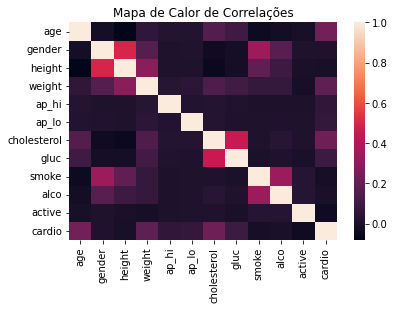

In [13]:
sns.heatmap(df.drop(features_remover, axis=1).corr())
plt.title('Mapa de Calor de Correlações');

1. moderada entre altura e gênero
2. moderada entre colesterol e glicemia
3. moderada entre consumidores de alcool e fumantes
4. moderada entre fumantes e idade
5. várias correlações fracas

In [14]:
df[features_numéricas].describe()

,age_,height,weight,ap_hi,ap_lo
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,52.840671,164.359229,74.205690,128.817286,96.630414
std,6.766774,8.210126,14.395757,154.011419,188.472530
min,29.000000,55.000000,10.000000,-150.000000,-70.000000
25%,48.000000,159.000000,65.000000,120.000000,80.000000
50%,53.000000,165.000000,72.000000,120.000000,80.000000
75%,58.000000,170.000000,82.000000,140.000000,90.000000
max,64.000000,250.000000,200.000000,16020.000000,11000.000000


1. Nada discrepante em idade
2. Pessoas com alturas desde 55 centímetros até 2 metros e meio, aparentemente com discrepancias
3. Pessoas com 10kgs (discrepante uma vez que a idade mínima é 29 anos)
4. Máxima da pressão com número negativo em mínimo e 16020 em máximo (possivel erro de escala)
5. Mínima da pressão com número negativo em mínimo e 11000 em máximo (provável erro de escala)

##### 2.3.4 Bivariate Analytics with Target

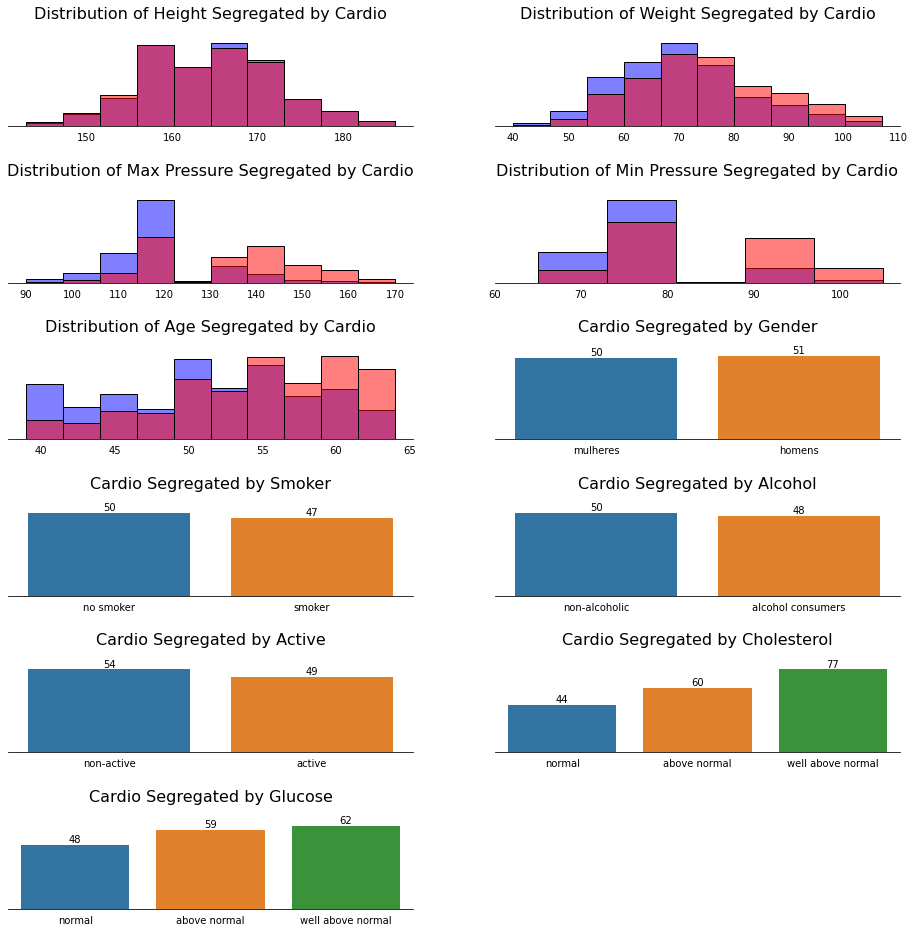

In [166]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace = 0.8)
plt.subplot(6, 2, 1)
indices_outliers, li, ls = buscar_outliers(df, 'height')
ax = sns.histplot(data=df.drop(indices_outliers).loc[df['cardio']==0], x='height', bins=10, color='b', alpha=0.5)
ax = sns.histplot(data=df.drop(indices_outliers).loc[df['cardio']==1], x='height', bins=10, color='r', alpha=0.5)
plt.title('Distribution of Height Segregated by Cardio', fontsize=16, pad=20)
ax.tick_params(bottom=False, labelleft=False, left=False)
plt.ylabel('')
plt.xlabel('')
sns.despine(left=True)

plt.subplot(6, 2, 2)
indices_outliers, li, ls = buscar_outliers(df, 'weight')
ax = sns.histplot(data=df.drop(indices_outliers).loc[df['cardio']==0], x='weight', bins=10, color='b', alpha=0.5)
ax = sns.histplot(data=df.drop(indices_outliers).loc[df['cardio']==1], x='weight', bins=10, color='r', alpha=0.5)
plt.title('Distribution of Weight Segregated by Cardio', fontsize=16, pad=20)
ax.tick_params(bottom=False, labelleft=False, left=False)
plt.ylabel('')
plt.xlabel('')
sns.despine(left=True)

plt.subplot(6, 2, 3)
indices_outliers, li, ls = buscar_outliers(df, 'ap_hi')
ax = sns.histplot(data=df.drop(indices_outliers).loc[df['cardio']==0], x='ap_hi', bins=10, color='b', alpha=0.5)
ax = sns.histplot(data=df.drop(indices_outliers).loc[df['cardio']==1], x='ap_hi', bins=10, color='r', alpha=0.5)
plt.title('Distribution of Max Pressure Segregated by Cardio', fontsize=16, pad=20)
ax.tick_params(bottom=False, labelleft=False, left=False)
plt.ylabel('')
plt.xlabel('')
sns.despine(left=True)

plt.subplot(6, 2, 4)
indices_outliers, li, ls = buscar_outliers(df, 'ap_lo')
ax = sns.histplot(data=df.drop(indices_outliers).loc[df['cardio']==0], x='ap_lo', bins=5, color='b', alpha=0.5)
ax = sns.histplot(data=df.drop(indices_outliers).loc[df['cardio']==1], x='ap_lo', bins=5, color='r', alpha=0.5)
plt.xticks(range(60, 110, 10))
plt.title('Distribution of Min Pressure Segregated by Cardio', fontsize=16, pad=20)
ax.tick_params(bottom=False, labelleft=False, left=False)
plt.ylabel('')
plt.xlabel('')
sns.despine(left=True)

plt.subplot(6, 2, 5)
indices_outliers, li, ls = buscar_outliers(df, 'age')
ax = sns.histplot(data=df.drop(indices_outliers).loc[df['cardio']==0], x='age_', bins=10, color='b', alpha=0.5)
ax = sns.histplot(data=df.drop(indices_outliers).loc[df['cardio']==1], x='age_', bins=10, color='r', alpha=0.5)
plt.title('Distribution of Age Segregated by Cardio', fontsize=16, pad=20)
ax.tick_params(bottom=False, labelleft=False, left=False)
plt.ylabel('')
plt.xlabel('')
sns.despine(left=True)

plt.subplot(6, 2, 6)
temp = df.groupby('gender')['cardio'].value_counts(normalize=True).rename('values').reset_index()
temp = round(temp.loc[temp['cardio']==1], 2)*100
ax = sns.barplot(data=temp, x='gender', y='values', ci=None)
ax.tick_params(bottom=False, labelleft=False, left=False)
ax.set_xticklabels(['mulheres', 'homens'])
ax.bar_label(ax.containers[0])
plt.ylabel('')
plt.xlabel('')
sns.despine(left=True)
plt.title('Cardio Segregated by Gender', fontsize=16, pad=20)

plt.subplot(6, 2, 7)
temp = df.groupby('smoke')['cardio'].value_counts(normalize=True).rename('values').reset_index()
temp = round(temp.loc[temp['cardio']==1], 2)*100
ax = sns.barplot(data=temp, x='smoke', y='values', ci=None)
ax.tick_params(bottom=False, labelleft=False, left=False)
ax.set_xticklabels(['no smoker', 'smoker'])
ax.bar_label(ax.containers[0])
plt.ylabel('')
plt.xlabel('')
sns.despine(left=True)
plt.title('Cardio Segregated by Smoker', fontsize=16, pad=20)

plt.subplot(6, 2, 8)
temp = df.groupby('alco')['cardio'].value_counts(normalize=True).rename('values').reset_index()
temp = round(temp.loc[temp['cardio']==1], 2)*100
ax = sns.barplot(data=temp, x='alco', y='values', ci=None)
ax.tick_params(bottom=False, labelleft=False, left=False)
ax.set_xticklabels(['non-alcoholic', 'alcohol consumers'])
ax.bar_label(ax.containers[0])
plt.ylabel('')
plt.xlabel('')
sns.despine(left=True)
plt.title('Cardio Segregated by Alcohol', fontsize=16, pad=20)

plt.subplot(6, 2, 9)
temp = df.groupby('active')['cardio'].value_counts(normalize=True).rename('values').reset_index()
temp = round(temp.loc[temp['cardio']==1], 2)*100
ax = sns.barplot(data=temp, x='active', y='values', ci=None)
ax.tick_params(bottom=False, labelleft=False, left=False)
ax.set_xticklabels(['non-active', 'active'])
ax.bar_label(ax.containers[0])
plt.ylabel('')
plt.xlabel('')
sns.despine(left=True)
plt.title('Cardio Segregated by Active', fontsize=16, pad=20)

plt.subplot(6, 2, 10)
temp = df.groupby('cholesterol')['cardio'].value_counts(normalize=True).rename('values').reset_index()
temp = round(temp.loc[temp['cardio']==1], 2)*100
ax = sns.barplot(data=temp, x='cholesterol', y='values', ci=None)
ax.tick_params(bottom=False, labelleft=False, left=False)
ax.set_xticklabels(['normal', 'above normal', 'well above normal'])
ax.bar_label(ax.containers[0])
plt.ylabel('')
plt.xlabel('')
sns.despine(left=True)
plt.title('Cardio Segregated by Cholesterol', fontsize=16, pad=20)

plt.subplot(6, 2, 11)
temp = df.groupby('gluc')['cardio'].value_counts(normalize=True).rename('values').reset_index()
temp = round(temp.loc[temp['cardio']==1], 2)*100
ax = sns.barplot(data=temp, x='gluc', y='values', ci=None)
ax.tick_params(bottom=False, labelleft=False, left=False)
ax.set_xticklabels(['normal', 'above normal', 'well above normal'])
ax.bar_label(ax.containers[0])
plt.ylabel('')
plt.xlabel('')
sns.despine(left=True)
plt.title('Cardio Segregated by Glucose', fontsize=16, pad=20);

##### 2.3.5 Individual Numerical Feature Analysis

###### height

In [15]:
outliers_indices, li, ls = buscar_outliers(df, 'height')

In [16]:
print(f'Limite inferior: {li} \nLimite superior: {ls}')

Limite inferior: 142.5 
Limite superior: 186.5


In [17]:
print(f'Quantidade total de amostras outliers: {df.loc[outliers_indices, "id"].count()}')
print(f'Quantidade de amostas maiores que 186.5cm: {df.loc[df["height"] > 186.5, "id"].count()}')
print(f'Quantidade de amostas menores que 142.5cm: {df.loc[df["height"] < 142.5, "id"].count()}')

Quantidade total de amostras outliers: 519
Quantidade de amostas maiores que 186.5cm: 269
Quantidade de amostas menores que 142.5cm: 250


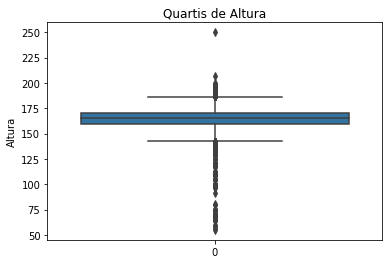

In [18]:
sns.boxplot(data=df['height'])
plt.title('Quartis de Altura')
plt.ylabel('Altura');

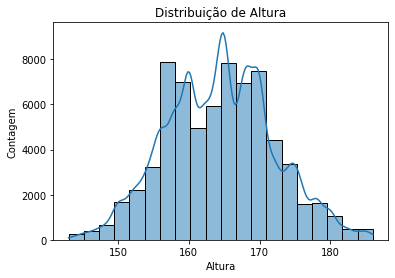

In [19]:
sns.histplot(df.drop(outliers_indices)['height'], bins=20, kde=True)
plt.title('Distribuição de Altura')
plt.xlabel('Altura')
plt.ylabel('Contagem');

Aparentemente há duas modas, e o gerador provavelmente é o gênero

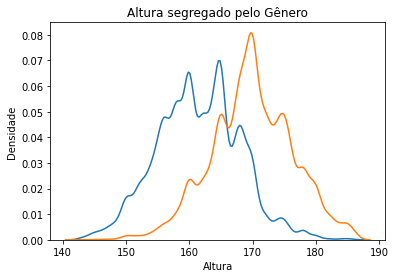

In [20]:
sns.kdeplot(df.drop(outliers_indices).loc[df['gender']==1, 'height'])
sns.kdeplot(df.drop(outliers_indices).loc[df['gender']==2, 'height'])
plt.title('Altura segregado pelo Gênero')
plt.xlabel('Altura')
plt.ylabel('Densidade');

In [21]:
desc_stats(df, 'height')

Dados da feature: height

Máximo (max): 250
Mínimo (min): 55
Range (range): 195
Média (mean): 164.35922857142856
Mediana (median): 165.0
Desvio padrão (standard deviation): 8.210126364538038
Curtose (kurtosis): 7.943652579423719
Assimetria (skew): -0.6421874521557643


###### weight

In [22]:
outliers_indices, li, ls = buscar_outliers(df, 'weight')

In [23]:
print(f'Limite inferior: {li} \nLimite superior: {ls}')

Limite inferior: 39.5 
Limite superior: 107.5


In [24]:
print(f'Há um total de {len(outliers_indices)} outliers')
print(f'Há um total de: {df.loc[df["weight"]<li, "id"].count()} outliers com peso mais BAIXO que a normalidade')
print(f'Há um total de: {df.loc[df["weight"]>ls, "id"].count()} outliers com peso mais ALTO que a normalidade')

Há um total de 1819 outliers
Há um total de: 52 outliers com peso mais BAIXO que a normalidade
Há um total de: 1767 outliers com peso mais ALTO que a normalidade


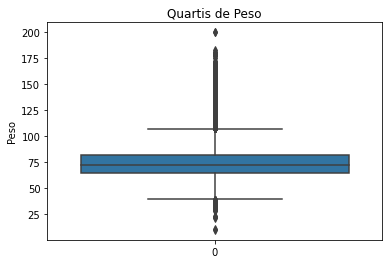

In [25]:
sns.boxplot(data=df['weight'])
plt.title('Quartis de Peso')
plt.ylabel('Peso');

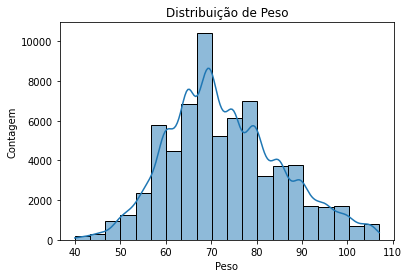

In [26]:
sns.histplot(df.drop(outliers_indices)['weight'], bins=20, kde=True)
plt.title('Distribuição de Peso')
plt.xlabel('Peso')
plt.ylabel('Contagem');

In [27]:
desc_stats(df, 'weight')

Dados da feature: weight

Máximo (max): 200.0
Mínimo (min): 10.0
Range (range): 190.0
Média (mean): 74.20569
Mediana (median): 72.0
Desvio padrão (standard deviation): 14.39575667851138
Curtose (kurtosis): 2.5868254500056223
Assimetria (skew): 1.0120701082089065


###### age

In [28]:
outliers_indices, li, ls = buscar_outliers(df, 'age_')
len(outliers_indices)

4

In [29]:
df.loc[outliers_indices]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_
6219,8850,10878,1,175,59.0,120,80,1,1,0,0,1,0,29
22343,31922,10798,2,175,92.0,100,60,1,1,0,0,1,0,29
30666,43842,10859,1,159,59.0,120,80,1,1,0,0,1,0,29
55905,79749,10964,1,160,59.0,110,70,1,1,0,0,1,0,30


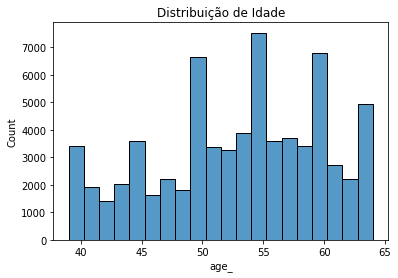

In [30]:
sns.histplot(df.drop(outliers_indices)['age_'], bins=20)
plt.title('Distribuição de Idade');

Pessoas jovens com idades até 30 anos são outliers

In [31]:
desc_stats(df, 'age_')

Dados da feature: age_

Máximo (max): 64
Mínimo (min): 29
Range (range): 35
Média (mean): 52.840671428571426
Mediana (median): 53.0
Desvio padrão (standard deviation): 6.766773653742167
Curtose (kurtosis): -0.8189809196744138
Assimetria (skew): -0.30574389867589913


###### ap_hi

In [32]:
outliers_indices, li, ls = buscar_outliers(df, 'ap_hi')

print(f'Há um total de {len(outliers_indices)} outliers')
print(f'Há um total de: {df.loc[df["ap_hi"]<li, "id"].count()} outliers com Máxima de Pressão mais BAIXO que a normalidade')
print(f'Há um total de: {df.loc[df["ap_hi"]>ls, "id"].count()} outliers com Máxima de Pressão mais ALTO que a normalidade')

Há um total de 1435 outliers
Há um total de: 321 outliers com Máxima de Pressão mais BAIXO que a normalidade
Há um total de: 1114 outliers com Máxima de Pressão mais ALTO que a normalidade


In [33]:
desc_stats(df, 'ap_hi')

Dados da feature: ap_hi

Máximo (max): 16020
Mínimo (min): -150
Range (range): 16170
Média (mean): 128.8172857142857
Mediana (median): 120.0
Desvio padrão (standard deviation): 154.01141945609137
Curtose (kurtosis): 7580.07473772039
Assimetria (skew): 85.29621385553034


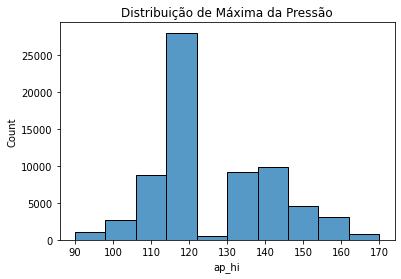

In [34]:
sns.histplot(df.drop(outliers_indices)['ap_hi'], bins=10)
plt.title('Distribuição de Máxima da Pressão');

Esperava-se que entre os limites 120 e 130 houvesse uma população maior, pela proximidade com a média

In [35]:
df['ap_hi'].mean()

128.8172857142857

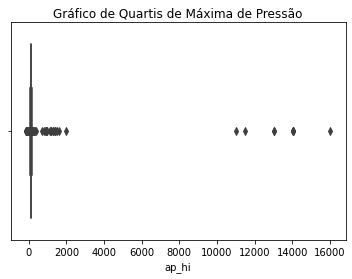

In [36]:
sns.boxplot(x='ap_hi', data=df)
plt.title('Gráfico de Quartis de Máxima de Pressão');

Há uma população entre 10000 e 16000 bastante distante do quarto quartil, e distante também dos outros outliers. Possivelmente sejam erros de escala no imput, parecem ser 100 vezes maiores do que os valores "normais"

In [37]:
df['ap_hi'].describe()

count    70000.000000
mean       128.817286
std        154.011419
min       -150.000000
25%        120.000000
50%        120.000000
75%        140.000000
max      16020.000000
Name: ap_hi, dtype: float64

Valores negativos

In [38]:
df.loc[df['ap_hi']<0]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_
4607,6525,15281,1,165,78.0,-100,80,2,1,0,0,1,0,41
16021,22881,22108,2,161,90.0,-115,70,1,1,0,0,1,0,60
20536,29313,15581,1,153,54.0,-100,70,1,1,0,0,1,0,42
23988,34295,18301,1,162,74.0,-140,90,1,1,0,0,1,1,50
25240,36025,14711,2,168,50.0,-120,80,2,1,0,0,0,1,40
35040,50055,23325,2,168,59.0,-150,80,1,1,0,0,1,1,63
46627,66571,23646,2,160,59.0,-120,80,1,1,0,0,0,0,64


Todos os valores parecem condizer com medições de máximas de pressão, caso fossem positivos

###### ap_lo

In [39]:
outliers_indices, li, ls = buscar_outliers(df, 'ap_lo')

print(f'Há um total de {len(outliers_indices)} outliers')
print(f'Há um total de: {df.loc[df["ap_lo"]<li, "id"].count()} outliers com Mínima de Pressão mais BAIXO que a normalidade')
print(f'Há um total de: {df.loc[df["ap_lo"]>ls, "id"].count()} outliers com Mínima de Pressão mais ALTO que a normalidade')

Há um total de 4632 outliers
Há um total de: 2932 outliers com Mínima de Pressão mais BAIXO que a normalidade
Há um total de: 1700 outliers com Mínima de Pressão mais ALTO que a normalidade


In [40]:
desc_stats(df, 'ap_lo')

Dados da feature: ap_lo

Máximo (max): 11000
Mínimo (min): -70
Range (range): 11070
Média (mean): 96.63041428571428
Mediana (median): 80.0
Desvio padrão (standard deviation): 188.47253029639026
Curtose (kurtosis): 1425.9145849479457
Assimetria (skew): 32.114082834816884


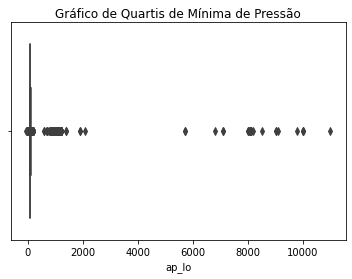

In [41]:
sns.boxplot(x='ap_lo', data=df)
plt.title('Gráfico de Quartis de Mínima de Pressão');

Do mesmo modo que a ap_hi, há uma população de outliers com valores compatíveis com os valores comuns, mas com um tipo de erro de escala. Os valores são 100 vezes maiores. Um teste pode demonstrar se tais outliers são os mesmos outliers que estão presentes em ap_hi em tais características de erro de escala

In [69]:
df.loc[df['ap_lo']>4000, 'id'].count()

24

A quantidade é irrelevante, não demanda estudos e correções.

## 2.4 Data Cleaning

# 3.0 Feature Engineering

# 4.0 Business Hypothesis

# 5.0 Exploratory Data Analysis

# 6.0 Data Preparation

In [43]:
X = df.drop(features_remover+features_target, axis=1)
X = np.array(X)
y = df[features_target]
y = np.array(y).reshape(1, len(y))[0]

In [44]:
X = np.array(X)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [46]:
scaler = StandardScaler()

scaler = scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# 7.0 Machine Learning

###### Model description

In [47]:
rf_model = RandomForestClassifier()

###### Fiting model

In [48]:
rf_fit = rf_model.fit(X_train, y_train)

###### Predicts

In [49]:
rf_predict = rf_fit.predict(X_test)

###### Metrics

In [50]:
print(classification_report(y_test, rf_predict))

              precision    recall  f1-score   support

           0       0.71      0.73      0.72     10543
           1       0.72      0.70      0.71     10457

    accuracy                           0.71     21000
   macro avg       0.71      0.71      0.71     21000
weighted avg       0.71      0.71      0.71     21000



# 8.0 Results and Conclusions

# Time

In [51]:
print(f'O tempo de processamento do projeto foi de: {int(round(time.time()-tempo_agora, 2)/60)} minutos')

O tempo de processamento do projeto foi de: 0 minutos
